# Fake News Detection 

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
import pickle
from sklearn.metrics import accuracy_score, f1_score
from nltk.util import ngrams
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import gensim
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
""" The following imports are used for getting bert embedings.
    The embeddings were pickle and saved since running this takes up to an hour"""
# from flair.embeddings import TransformerWordEmbeddings
# from flair.data import Sentence
# import torch
# from nltk.tokenize import sent_tokenize
# import gc

' The following imports are used for getting bert embedings.\n    The embeddings were pickle and saved since running this takes up to an hour'

## Reading the Data

In [2]:
data = pd.read_csv('data/train.csv', sep='\t')

## Discovering the Data

We start off with a quick glance at the data. 

In [3]:
data.head()

,text,label
0,Get the latest from TODAY Sign up for our news...,1
1,2d Conan On The Funeral Trump Will Be Invited...,1
2,It’s safe to say that Instagram Stories has fa...,0
3,Much like a certain Amazon goddess with a lass...,0
4,At a time when the perfect outfit is just one ...,0


In [4]:
data.shape

(4987, 2)

Let's start with investigating the target variable.

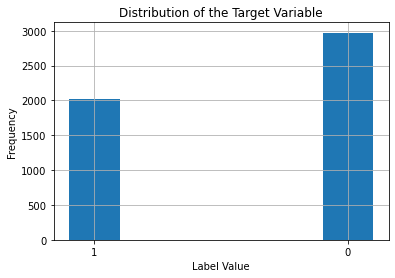

In [5]:
bins = [-.1, .1, .9, 1.1]
data['label'].hist(bins=bins)
plt.title('Distribution of the Target Variable')
plt.xlabel('Label Value')
plt.ylabel('Frequency')
plt.show()

The histogram shows that the data is not balanced. We have to keep this in mind when evaluating the performance of the models and avoid some metrics that would mislead us.

Something else to notice is the third value **label** on the x-axis. Let's have a closer look to see what that is. 

In [6]:
data['label'].value_counts()

0        2972
1        2014
label       1
Name: label, dtype: int64

There is a single value called label. It could be a missing value. Let's look at that row in the dataframe.

In [7]:
data.loc[data['label']=='label']

,text,label
1615,content,label


The whole row is junk. We will delete it. 

In [8]:
data = data.drop(1615)

In [9]:
data['label'].value_counts()

0    2972
1    2014
Name: label, dtype: int64

Let's make sure we don't have any missing values.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4986 entries, 0 to 4986
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4986 non-null   object
 1   label   4986 non-null   object
dtypes: object(2)
memory usage: 116.9+ KB


In [11]:
data.isnull().any()

text     False
label    False
dtype: bool

It seems that we don't have any missing values. 


Now, let's investigate the single feature we have **text**. We start with learning some statistics about this feature e.g. the length of the article. 

Average length: 661.996991576414 



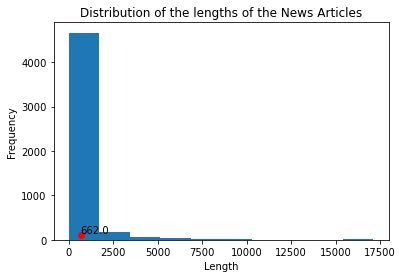

In [12]:
article_lengths = [len(line.split()) for line in data['text']]
avg_len = np.mean(article_lengths) 
print(f'Average length: {avg_len} \n')
plt.hist(article_lengths) 
plt.plot(avg_len, 100 ,'ro') 
plt.annotate(round(avg_len, 2), (avg_len, 160))
plt.title('Distribution of the lengths of the News Articles')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

Most of the lengths are below 2500. We will have to truncate the samples to a specific length later.  

Now, let's look at the common bigrams (combination of 2 words) in both classes: fake and not fake.  

In [13]:
fake = data.loc[data['label']=='1'].reset_index(drop=True)
not_fake = data.loc[data['label'] == '0'].reset_index(drop=True)

In [14]:
fake.head()

,text,label
0,Get the latest from TODAY Sign up for our news...,1
1,2d Conan On The Funeral Trump Will Be Invited...,1
2,"On March 24, 2018, one month and ten days afte...",1
3,A mosque in Georgia is under fire after they s...,1
4,Scott Disick is sticking up for Khloe Kardashi...,1


In [15]:
not_fake.head()

,text,label
0,It’s safe to say that Instagram Stories has fa...,0
1,Much like a certain Amazon goddess with a lass...,0
2,At a time when the perfect outfit is just one ...,0
3,"When Reese Witherspoon was 17, she had already...",0
4,It’s official! WAGS Miami stars Ashley Nicole ...,0


In [16]:
def get_top_n_bigrams(n, corpus):
    """ Returns the most probable n bigrams in the given corpus"""
    vec = TfidfVectorizer(ngram_range=(2, 2),use_idf=False)
    matrix = vec.fit_transform(corpus).toarray()
    vocabulary = vec.get_feature_names() 
    return sorted(zip(matrix[0], vocabulary), key=lambda t: t[0])[-n:]

In [17]:
fake_corpus = [' '.join(fake['text'])]
df = pd.DataFrame(get_top_n_bigrams(5, fake_corpus))
df.columns = ['probability', 'bigram']
df = df[['bigram', 'probability']]
df

,bigram,probability
0,at the,0.189514
1,to the,0.193482
2,on the,0.217805
3,in the,0.430540
4,of the,0.438623


In the fake articles, all of the top n bigrams are stop words. Those are words that are very common in the language and don't carry a lot of information.

In [18]:
not_fake_corpus = [' '.join(not_fake['text'])]
df = pd.DataFrame(get_top_n_bigrams(5, not_fake_corpus))
df.columns = ['probability', 'bigram']
df = df[['bigram', 'probability']]
df

,bigram,probability
0,at the,0.183098
1,to the,0.202521
2,on the,0.211595
3,in the,0.407152
4,of the,0.473564


Again here, as expected, the most common bigrams are stop words. 


The expectations is that we don't see these after cleaning the data of those stop words. 

## Cleaning the Data

The text feature contains raw text. The text needs to be cleaned before vectorizing it to get rid the tokens that would hurt the model. Tokens like punctuations, qoutation marks, emojis, links..etc. Such tokens could actually contribute to the target's value e.g. fake news usually contain punctuations, however, we tackle the task first using the clean text. We may later engineer more such features to help us improve the models' performance. 


Let's look at one news article before cleaning it.

In [19]:
text = data['text'][0]
text

'Get the latest from TODAY Sign up for our newsletter  No one ever truly gets over losing a loved one, and Blake Shelton is no exception. He was just 14 when his older brother Richie died on Nov. 13, 1990. And, as Shelton noted in a tweet Monday, "It changed my life forever."  Richie was 24 when he died in a car accident in the Sheltons\' home state of Oklahoma. Two years ago, Shelton sent out a message for the 25th anniversary of his loss:  Richie, who was Blake\'s half-brother (they shared a mother), was a passenger in a car that collided with a school bus in Ada, south of Oklahoma City.  Richie, driver Redena McManus and a 3-year-old boy, Christopher McManus, all died during or shortly after the collision, while the bus driver and passengers were uninjured, according to police reports.  The accident has clearly remained with Blake, who told 60 Minutes in 2014, "I remember picking up the phone to call him a week after he was dead, to tell him something. I was picking up the phone to 

The text contains some junk that we need to clean. We will clean the text in the following steps: 

1) Removing punctuations.
2) Removing digits.
3) Remove the empty string, the one charachter tokens, and stop-words.

The following function applies the above steps.

In [20]:
def clean_text(text):
    """ Cleans a given text from punctuations, stop words, and numbers"""
    stop_w = stopwords.words('English')
    words = re.split(r'\W+', text)  #punctionation
    string_words = ' '.join((item for item in words if not item.isdigit())) #numbers
    tokens = [token.lower() for token in string_words.split(" ") if (token != "" and len(token)>1 and token not in stop_w)]  
    return tokens

Let's now look at the output of the function.

In [21]:
print(clean_text(text))

['get', 'latest', 'today', 'sign', 'newsletter', 'no', 'one', 'ever', 'truly', 'gets', 'losing', 'loved', 'one', 'blake', 'shelton', 'exception', 'he', 'older', 'brother', 'richie', 'died', 'nov', 'and', 'shelton', 'noted', 'tweet', 'monday', 'it', 'changed', 'life', 'forever', 'richie', 'died', 'car', 'accident', 'sheltons', 'home', 'state', 'oklahoma', 'two', 'years', 'ago', 'shelton', 'sent', 'message', '25th', 'anniversary', 'loss', 'richie', 'blake', 'half', 'brother', 'shared', 'mother', 'passenger', 'car', 'collided', 'school', 'bus', 'ada', 'south', 'oklahoma', 'city', 'richie', 'driver', 'redena', 'mcmanus', 'year', 'old', 'boy', 'christopher', 'mcmanus', 'died', 'shortly', 'collision', 'bus', 'driver', 'passengers', 'uninjured', 'according', 'police', 'reports', 'the', 'accident', 'clearly', 'remained', 'blake', 'told', 'minutes', 'remember', 'picking', 'phone', 'call', 'week', 'dead', 'tell', 'something', 'picking', 'phone', 'call', 'tell', 'something', 'saw', 'tv', 'like', 

We applied the function to only a single row. Let's apply the function to the whole dataset. 

In [22]:
data['text'] = data['text'].apply(lambda x: clean_text(x))

Let's look at the articles' lengths now. 

Average length: 393.6187324508624 



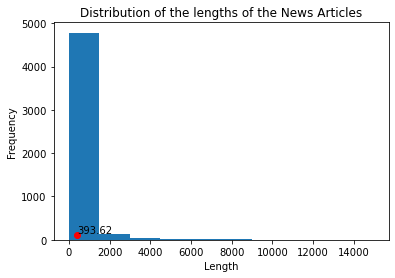

In [23]:
article_lengths = [len(line) for line in data['text']]
avg_len = np.mean(article_lengths) 
print(f'Average length: {avg_len} \n')
plt.hist(article_lengths) 
plt.plot(avg_len, 100 ,'ro') 
plt.annotate(round(avg_len, 2), (avg_len, 160))
plt.title('Distribution of the lengths of the News Articles')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

The average length dropped from about 661 to almost 394. Besides, we don't see wild lengths (beyond 10k) as we saw earlier.  

Before we move on, let's look at the most common bigrams again after cleaning the data. 

In [24]:
fake = data.loc[data['label']=='1'].reset_index(drop=True)
not_fake = data.loc[data['label'] == '0'].reset_index(drop=True)

In [25]:
fake_corpus = [' '.join([' '.join(text) for text in fake['text']])]
df = pd.DataFrame(get_top_n_bigrams(10, fake_corpus))
df.columns = ['probability', 'bigram']
df = df[['bigram', 'probability']]
df

,bigram,probability
0,donald trump,0.104320
1,meghan markle,0.109695
2,prince harry,0.110959
3,kim kardashian,0.115701
4,united states,0.138146
5,brad pitt,0.143836
6,getty images,0.151739
7,los angeles,0.184299
8,year old,0.236460
9,new york,0.270601


In [26]:
not_fake_corpus = [' '.join([' '.join(text) for text in not_fake['text']])]
df = pd.DataFrame(get_top_n_bigrams(10, not_fake_corpus))
df.columns = ['probability', 'bigram']
df = df[['bigram', 'probability']]
df

,bigram,probability
0,donald trump,0.090138
1,york city,0.095077
2,first time,0.102486
3,prince harry,0.105943
4,social media,0.132615
5,los angeles,0.141011
6,united states,0.153112
7,getty images,0.233866
8,year old,0.270415
9,new york,0.332154


We don't see any of the stop words we saw last time. The bigrams give us a clue about what the news talk about, but we can't tell why e.g. the donald trump bigram in the fake corpus could be an indicator of fake news and the one in the not-fake corpus is an indicator of true news. The context matters a lot. Maybe the verbs used in the context decide that, or even the nouns.  

## Vectorization

At this point, our data is clean. However, we need to represent each news article as an embedding vector. Vectorization can be done in many ways. There are simple methods such as TFIDF and sophisticated methods such as Word2Vec and Bert. We assume that Bert embeddings would perform better the the simple TFIDF embeddings. We will use the model trained with TFIDF embeddings as the baseline and benchmark the models trained with Bert embeddings against it. We also use Word2Vec embeddings besides the former two methods.  

### TFIDF

TF-IDF stands for Term Frequency and Inverse Document Frequency. Term Frequency is bascially the frequency of a word in a document. We could use the frequency alone as a weight for each word. However, this is misleading because the frequency of a word does not necessarily tell us that. TFIDF handles this by normalizing these frequencies by the inverse document frequency, which captures the rarity of the word. Due to this simplicity of the method, it does not capture any semantic of the words. Besides, it produces a sparse matrix of size N*V, where n is the number of documents and V is the size of the Vocabulary, all the unique words in the text. 

In [27]:
texts = [' '.join(text) for text in data['text'].values]

In [28]:
tfidf_vectorizer = TfidfVectorizer()

In [29]:
tfidf_embeddings = tfidf_vectorizer.fit_transform(texts)

In [30]:
tfidf_embeddings = tfidf_embeddings.toarray()

In [31]:
tfidf_embeddings.shape

(4986, 62335)

### Word2Vec 


Word2Vec is a more sophisticated approach than TFIDF. It tries to learn an embedding vector for a word from its context. A model tries to predict a word given its context. In the end, we don't use those probabilities, but the weights of the neural netwroks as vector representations of the words. Word2Vec produces a dense vector. The size is generally 100-300. Due to this sophisticated method, the embedding vectors carry semantic information. Hence, applying vector operations on the embeddings vectors produces meaning results. 


The model below takes as an input a word. For our case, we need a vector representaiton for the whole document not just for a single word in the document. To tackle this problem, we get the embedding of each word then average all the vectors to end up with a single vector representing the document. 



In [32]:
w2v_model = Word2Vec(data['text'], vector_size = 300, window = 5, sg=1)

In [33]:
def get_w2v_embeddings(corpus):
    w2v_embeddings = []
    for text in corpus:
        word_embeddings = []
        for word in text:
            if not word in w2v_model.wv: continue  
            word_embeddings.append(w2v_model.wv[word])
        doc_embedding = np.mean(np.array(word_embeddings), axis=0)
        w2v_embeddings.append(doc_embedding)
    w2v_embeddings = np.array(w2v_embeddings)
    return w2v_embeddings

In [34]:
w2v_embeddings = get_w2v_embeddings(data['text'])

In [35]:
w2v_embeddings.shape

(4986, 300)

### BERT


Bert is a context dependent model. It captures all the word senses of a word. The input to the model is not a single word but a sentence. For example, the vector representation of a word depends on the sense of the word in that context. Word2Vec, on the other hand, would represent a word with a single vector for all the senses. Besides, Bert takes into account the position of the word unlike Word2Vec and TFIDF. 


Bert takes as an input a sentence, not a single word. That sentence's length should not exceed 512. And as we have seen above, some documents' length is way more than this. Therefore, we split such long documents into chunks to be able to input them to Bert. Then, as we did for Word2Vec, we get the embedding vector for each word in a document and average them to have a single embedding representation for the document.  


In [36]:
"""" This cell takes up to an hour to finish. 
    We pickled the embeddings so there would be no need to rerun it again"""

def encode_text(text): 
    """ Returns a single bert vector representation for a text of any length"""
    word_embeds = []
    tokens = np.array(text.split())
    num_sents = (len(tokens) + 512-1) // 512
    sentences = np.array_split(tokens,  num_sents)
    for idx, sent in enumerate(sentences):
        sentence = Sentence(' '.join(sent))
        embeddings.embed(sentence)
        for tok in sentence: 
            word_embeds.append(tok.embedding.cpu().detach().numpy())
        gc.collect()
        torch.cuda.empty_cache()
    res = np.mean(np.array(word_embeds), axis=0)
    return res

def get_bert_embeddings():
    """ Iterates through all the documents and embeds one at a time"""
    embeddings = TransformerWordEmbeddings('bert-base-uncased')
    bert_embeddings = []
    for text in texts:
        embed = encode_text(' '.join(text)) 
        bert_embeddings.append(embed)
    return bert_embeddings

Let's load the pickled embeddigns of the articles.

In [37]:
with open('data/bert_embeddings.pickle', 'rb') as f:
    bert_embeddings = np.array(pickle.load(f))

In [38]:
bert_embeddings.shape

(4986, 768)

## Preprocessing the Data 


Before using the embeddings to train our models, we organize the data we have and preprocess the data such as scaling and splitting the data. We also have the option of reducing the dimensionality of our data using PCA.  

In [39]:
X = {'tfidf': tfidf_embeddings, 'w2v': w2v_embeddings, 'bert': bert_embeddings}
y = data['label'].astype(int)

class Data:
    """This class handles the preprocessing of the data: splitting, scaling, PCA"""
    def __init__(self, X, y, embed='tfidf'):
        self.embed = embed
        self.X = X[self.embed]
        self.y = y
    
    def get_data(self, scaled=False, pca=False):
        """Returns the splitted data. Scaled if scaled=True. Transformed with PCA if pca=True"""
        X_train, X_test, y_train, y_test = self.split_data()
        if pca: X_train, X_test = self.pca_data(X_train, X_test)
        if scaled: X_train, X_test = self.scaled_data(X_train, X_test)
        return X_train, X_test, y_train, y_test
    
    def split_data(self):
        """Splits the data into training and testing (.2 of the data)"""
        return train_test_split(self.X, self.y, test_size=0.2, random_state=42)
   
    def pca_data(self, X_train, X_test):
        """Transforms the data using PCA"""
        X_train, X_test = self.scaled_data(X_train, X_test)
        pca = PCA(.95)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        return X_train, X_test
        
    def scaled_data(self, X_train, X_test):
        """Scales the data using the standard scaler"""
        if self.embed == 'tfidf': return X_train, X_test
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        return X_train, X_test

In [40]:
tfidf_data = Data(X, y, embed='tfidf')
w2v_data = Data(X, y, embed='w2v')
bert_data = Data(X, y, embed='bert')

## Modelling


Now, it is time to train some models on the embeddings we have. We train several classification mehtods compare their results. We compare the results of the models on the actual data and the data transformed with PCA. We combine differnt models of different embedding techniques (TFIDF, Word2Vec, and Bert) and have a voting system on their output. Finally, we interpret the results and discuss some possible improvements.


We start with defninig a class and some functions to organize the section.

In [41]:
class Model():
    """This class organizes the modelling process"""
    def __init__(self, model):
        self.model = model
        
    def train(self, X, y):
        """trains the model on the given X and y training data"""
        self.model.fit(X, y)
    
    def accuracy_score(self, X, y, cv=False): 
        """Returns the accuracy score. cv=True will cause it to return the mean of scores"""
        if cv: return np.mean(cross_val_score(self.model, X, y, cv=3, scoring='accuracy'))
        preds = self.model.predict(X)
        return accuracy_score(y, preds)
    
    def f1_score(self, X, y, cv=False):
        """Returns the f1_score. cv=True will cause it to return the mean of the scores"""
        if cv: return np.mean(cross_val_score(self.model, X, y, cv=3, scoring='f1'))
        preds = self.model.predict(X) 
        return f1_score(y, preds)


In [42]:
def get_results_dict(models, data_all, pca=False):
    """Returns a result dict of all embeddings methods for all methods for all the metrics"""
    scores_ = {}
    for key, data in data_all.items():
        X_train, X_test, y_train, y_test =  data.get_data(pca=pca, scaled=True) 
        sub_scores = {}
        for model_name, model in models.items(): 
            clf = Model(model)
            clf.train(X_train, y_train)
            scores = [clf.accuracy_score(X_train, y_train, cv=True), clf.accuracy_score(X_train, y_train),
                      clf.accuracy_score(X_test, y_test), clf.f1_score(X_train, y_train, cv=True),
                      clf.f1_score(X_train, y_train), clf.f1_score(X_test, y_test)]
            sub_scores[model_name] = scores 
        scores_[key] = sub_scores
    return scores_

In [43]:
def show_result_tables(result_dict, indexes):
    """This functions shows the result tables given the result dict"""
    score_names = ['Accuracy Score (CV=3)', 'Accuracy Score (Train)', 'Accuracy Score (Test)', 'F1_Score (CV=3)', 'F1_Score (Train)', 'F1_Score (Test)']
    for key, val in result_dict.items():
        scrs = np.array(list(val.values()))
        df = pd.DataFrame(scrs)
        df.index = indexes
        df.columns = score_names
        display(df)

Now, let's look at the results using the actual data without applying PCA.

In [44]:
models = {'lg': LogisticRegression(C=.5), 'svc':  LinearSVC(C=.01) , 'rf': RandomForestClassifier(max_depth=5)}
data_all = {'tfidf': tfidf_data, 'w2v': w2v_data, 'bert': bert_data}

In [45]:
result_dict = get_results_dict(models, data_all)

In [198]:
indexes = ['Logistic Regression', 'LinearSVC', 'RandomForestClassifier']
show_result_tables(result_dict, indexes)

,Accuracy Score (CV=3),Accuracy Score (Train),Accuracy Score (Test),F1_Score (CV=3),F1_Score (Train),F1_Score (Test)
Logistic Regression,0.740471,0.802909,0.764529,0.571098,0.697460,0.643399
LinearSVC,0.657724,0.696841,0.678357,0.266510,0.408223,0.397749
RandomForestClassifier,0.633902,0.639920,0.608216,0.155641,0.183163,0.129176


,Accuracy Score (CV=3),Accuracy Score (Train),Accuracy Score (Test),F1_Score (CV=3),F1_Score (Train),F1_Score (Test)
Logistic Regression,0.738216,0.785607,0.765531,0.655043,0.712024,0.692105
LinearSVC,0.746742,0.786359,0.766533,0.660933,0.708618,0.691391
RandomForestClassifier,0.742478,0.792377,0.741483,0.599013,0.675803,0.603077


,Accuracy Score (CV=3),Accuracy Score (Train),Accuracy Score (Test),F1_Score (CV=3),F1_Score (Train),F1_Score (Test)
Logistic Regression,0.700098,0.844032,0.735471,0.628242,0.800000,0.674074
LinearSVC,0.718655,0.834504,0.751503,0.643527,0.784173,0.685279
RandomForestClassifier,0.699348,0.776830,0.689379,0.477175,0.633443,0.461806


### PCA

Here, we apply PCA transformation to the data first before running the above experiment. 

In [47]:
result_dict_pca = get_results_dict(models, data_all, pca=True)

In [200]:
show_result_tables(result_dict_pca, indexes)

,Accuracy Score (CV=3),Accuracy Score (Train),Accuracy Score (Test),F1_Score (CV=3),F1_Score (Train),F1_Score (Test)
Logistic Regression,0.742477,0.800401,0.765531,0.575510,0.693846,0.645455
LinearSVC,0.657472,0.695587,0.678357,0.267165,0.405485,0.397749
RandomForestClassifier,0.677532,0.746239,0.691383,0.382667,0.542909,0.465278


,Accuracy Score (CV=3),Accuracy Score (Train),Accuracy Score (Test),F1_Score (CV=3),F1_Score (Train),F1_Score (Test)
Logistic Regression,0.740472,0.768054,0.761523,0.647678,0.682021,0.680108
LinearSVC,0.742979,0.765045,0.761523,0.647398,0.673633,0.673973
RandomForestClassifier,0.721414,0.757773,0.719439,0.506109,0.579634,0.522184


,Accuracy Score (CV=3),Accuracy Score (Train),Accuracy Score (Test),F1_Score (CV=3),F1_Score (Train),F1_Score (Test)
Logistic Regression,0.721165,0.785105,0.741483,0.636818,0.717255,0.673418
LinearSVC,0.724174,0.783099,0.741483,0.639045,0.712720,0.665803
RandomForestClassifier,0.638415,0.696088,0.638277,0.186821,0.389113,0.246347


### Ensemble Method

In [48]:
def plot_distribution(y_true, predictions, voting):
    """plots the distributin of y(true) Vs. the predictions"""
    bins = [-.1, .1, .9, 1.1]
    plt.hist(y_true, alpha=.7, color='blue', label='true', bins=bins)
    plt.hist(predictions, color='red', label = 'predictions')
    plt.legend(fontsize=14)
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.title(f'{voting}: Gold Vs. Predictions')
    plt.show()

In [49]:
def ensemble(voting="soft"):
    svc = LinearSVC(C=.01)
    svc = CalibratedClassifierCV(svc) 
    lg = LogisticRegression(max_iter=2000, C=.5)
    data_to_use = [tfidf_data, w2v_data, bert_data]
    scores = []
    for idx, model in enumerate([Model(lg), Model(svc), Model(svc)]):
        X_train, X_test, y_train, y_test =  data_to_use[idx].get_data() 
        model.train(X_train, y_train)
        if voting=="soft":
            s1, s2 = model.model.predict_proba(X_train), model.model.predict_proba(X_test)
        else: 
            s1, s2 = model.model.predict(X_train), model.model.predict(X_test)
        scores.append([s1, s2])
    return scores

#### Hard Voting 

In [51]:
scores = ensemble(voting="hard")

In [232]:
train_preds = stats.mode(np.array([sc[0] for sc in scores]))[0][0]
test_preds = stats.mode(np.array([sc[1] for sc in scores]))[0][0]

In [266]:
def show_ensemble_table(y_train, y_test, train_preds, test_preds):
    res_d = {'accuracy score (train)': accuracy_score(y_train, train_preds), 'accuracy score (test)': accuracy_score(y_test, test_preds),
         'f1 score (train)': f1_score(y_train, train_preds), 'f1 score (test)': f1_score(y_test, test_preds)}
    df = pd.DataFrame(res_d, index=['ensemble'])
    return df
hard_df = show_ensemble_table(y_train, y_test, train_preds, test_preds)
hard_df

,accuracy score (train),accuracy score (test),f1 score (train),f1 score (test)
ensemble,0.777834,0.755511,0.678753,0.651429


In [234]:
hard_miss_count = len(y_test[y_test!=test_preds])
print(f'# of missclassified: {hard_miss_count}')

# of missclassified: 244


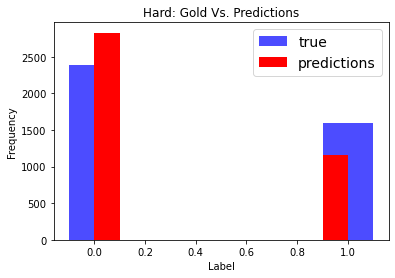

In [256]:
plot_distribution(y_train, train_preds, voting='Hard')

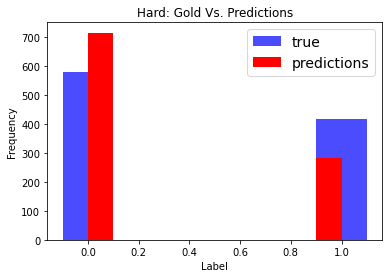

In [257]:
plot_distribution(y_test, test_preds, voting='Hard')

#### Soft Voting

In [247]:
scores = ensemble(voting="soft")

In [248]:
soft_train_preds = np.array([0 if i > j else 1 for i, j in np.mean(np.array([sc[0] for sc in scores]), axis=0)])
soft_test_preds = np.array([0 if i > j else 1 for i, j in np.mean(np.array([sc[1] for sc in scores]), axis=0)])

In [267]:
soft_df = show_ensemble_table(y_train, y_test, soft_train_preds, soft_test_preds)
soft_df

,accuracy score (train),accuracy score (test),f1 score (train),f1 score (test)
ensemble,0.787362,0.762525,0.692976,0.667602


In [250]:
soft_miss_count = len(y_test[y_test!=soft_test_preds])
print(f'# of missclassified: {soft_miss_count}')

# of missclassified: 237


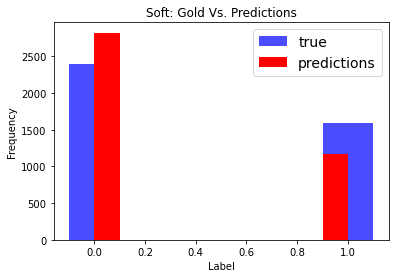

In [258]:
plot_distribution(y_train, soft_train_preds, voting='Soft')

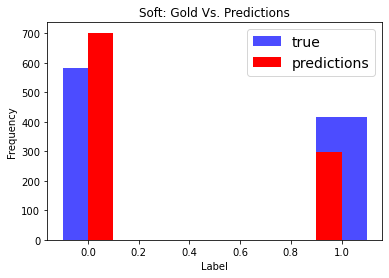

In [259]:
plot_distribution(y_test, soft_test_preds, voting='Soft')

## Kaggle Submission

In [243]:
test = pd.read_csv('data/test.csv', sep='\t')
test['text'] = test['text'].apply(lambda x: clean_text(x))
test_embeddings = get_w2v_embeddings(test['text'])
X_train, X_test, y_train, y_test = w2v_data.get_data(scaled=False)
test_m = RandomForestClassifier()
test_m.fit(X_train, y_train)
sub_preds = test_m.predict(test_embeddings)

In [61]:
submission = pd.DataFrame({'id' : test['id'], 'label' : sub_preds})

In [62]:
submission

,id,label
0,2,0
1,3,0
2,4,1
3,5,1
4,6,0
...,...,...
1242,1244,0
1243,1245,0
1244,1246,0
1245,1247,0


In [63]:
# submission.to_csv("submission.csv", index=False) # save to csv to submit